In [3]:
%load_ext lab_black

The lab_black extension is already loaded. To reload it, use:
  %reload_ext lab_black


In [11]:
import requests
import json
import os
import pathlib
import spacy

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from IPython.display import clear_output
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.ensemble import (
    RandomForestClassifier,
    ExtraTreesClassifier,
    StackingClassifier,
)
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import MaxAbsScaler
from sklearn.metrics import ConfusionMatrixDisplay

The cell below implements *everything* done in the previous notebook in a single cell, due to the fact that I forgot to save my model after the grid search completed. And it takes far too long to feasibly run again, so this is much quicker to implement and run.

In [10]:
corpus = (
    pd.read_csv("../data/corpus.csv")
    .sample(frac=1, random_state=43)
    .reset_index(drop=True)
)  # this statement was not given a random state in the previous notebook
# results may be slightly different as a result

target = "satire"
features = ["title", "article_text"]

train_corpus, test_corpus = train_test_split(
    corpus, random_state=43, stratify=corpus[target]
)

train_dummy = max([train_corpus[target].sum(), 1.0 - train_corpus[target].sum()])
test_dummy = max([test_corpus[target].sum(), 1.0 - test_corpus[target].sum()])

nlp = spacy.load("en_core_web_lg")


def lemmatize(corpus, nlp):
    lemmatized_lists = []
    for article in corpus:
        doc = nlp(article)

        lemmatized = [
            str(token.lemma_).lower()
            for token in doc
            if not token.is_stop
            and not token.is_punct
            and not token.is_oov
            and not token.is_space
        ]

        lemmatized_lists.append(lemmatized)

    return [" ".join(lemma_list) for lemma_list in lemmatized_lists]


def lemma_scores(lemmatized, y):
    lemma_counts = {}
    y = np.array(y)
    for n, lemmas in enumerate(lemmatized):
        for lemma in lemmas.split(" "):
            if lemma not in lemma_counts:
                lemma_counts[lemma] = [0, 0]
            lemma_counts[lemma][y[n]] += 1

    lemma_scores = {
        lemma: np.log(value[0] + value[1])
        * np.abs(value[0] - value[1])
        / (value[0] + value[1])
        for lemma, value in lemma_counts.items()
    }

    return lemma_scores


def score_filtering(lemmatized_corpus, lemma_scores, threshold):
    filtered_corpus = [
        " ".join(
            [
                lemma
                for lemma in lemmas.split(" ")
                if lemma_scores.get(lemma, 0) <= threshold
            ]
        )
        for lemmas in lemmatized_corpus
    ]

    return filtered_corpus


train_corpus["title"] = lemmatize(train_corpus["title"], nlp)
train_corpus["article_text"] = lemmatize(train_corpus["article_text"], nlp)

title_lemma_scores = lemma_scores(train_corpus["title"], train_corpus["satire"])
article_lemma_scores = lemma_scores(
    train_corpus["article_text"], train_corpus["satire"]
)

test_corpus["title"] = lemmatize(test_corpus["title"], nlp)
test_corpus["article_text"] = lemmatize(test_corpus["article_text"], nlp)

title_pipe = Pipeline(
    [
        ("title", ColumnTransformer([("vectorizer", TfidfVectorizer(), "title")])),
        ("model", RandomForestClassifier()),
    ]
)

article_pipe = Pipeline(
    [
        (
            "article",
            ColumnTransformer(
                [("vectorizer", CountVectorizer(max_features=10000), "article_text")]
            ),
        ),
        ("model", RandomForestClassifier()),
    ]
)

estimators = [("title_pipe", title_pipe), ("article_pipe", article_pipe)]
final_estimator = LogisticRegression(max_iter=100000)

model = StackingClassifier(
    estimators=estimators, final_estimator=final_estimator, n_jobs=-1
)

X_test = test_corpus[["article_text", "title"]].copy()
y_test = test_corpus["satire"].copy()

threshold = 5.0

X = train_corpus[["article_text", "title"]].copy()
y = train_corpus["satire"].copy()

X["title"] = score_filtering(X["title"], title_lemma_scores, threshold)
X["article_text"] = score_filtering(X["article_text"], article_lemma_scores, threshold)

model.fit(X, y)

StackingClassifier(estimators=[('title_pipe',
                                Pipeline(steps=[('title',
                                                 ColumnTransformer(transformers=[('vectorizer',
                                                                                  TfidfVectorizer(),
                                                                                  'title')])),
                                                ('model',
                                                 RandomForestClassifier())])),
                               ('article_pipe',
                                Pipeline(steps=[('article',
                                                 ColumnTransformer(transformers=[('vectorizer',
                                                                                  CountVectorizer(max_features=10000),
                                                                                  'article_text')])),
                                                ('model',
                                                 RandomForestClassifier())]))],
                   final_estimator=LogisticRegression(max_iter=100000),
                   n_jobs=-1)

In [28]:
model.score(X_test, y_test)

0.9543960558751027

The final model with the random states implemented has an accuracy of 95.4% on the test data. This is surprisingly good, and I attribute its success to the large amount of text acquired during data aggregation. Next, to see if there is a discrepancy in what is being misclassified. 

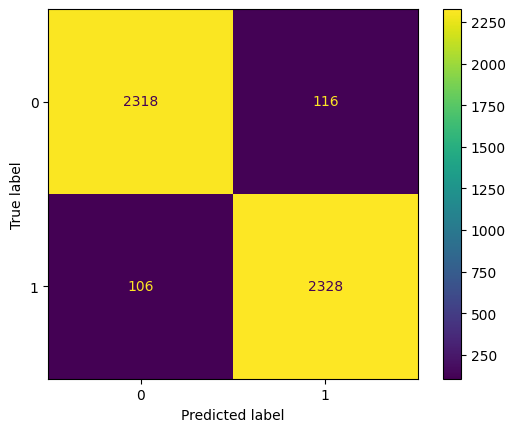

In [29]:
ConfusionMatrixDisplay.from_estimator(model, X_test, y_test)

Here, zero represents non-satirical and one represents satirical. The model predicts both incorrectly at roughly equal rates. There are slightly more real articles being classified as satirical than the converse, but it is not a significant difference. Overall, a very balanced model has been produced. It will be hard to determine what exactly is causing these examples to be misclassified, but to help reassure that there is nothing glaringly wrong with these examples I will print the first instances of a false negative and a false positive below.

In [39]:
# y_pred = model.predict(X_test)

X_test_arr, y_test_arr = np.array(X_test), np.array(y_test)

for n in range(len(X_test)):
    false_satire = y_test[n] == 0 and y_pred[n] == 1
    if false_satire:
        print("False Positive")
        print(X_test[n])
        print()
        break

for n in range(len(X_test)):
    false_real = y_test[n] == 1 and y_pred[n] == 0
    if false_real:
        print("False Negative")
        print(X_test[n])
        break

False Positive
['clinton county police officer earn praise admiration law enforcement official completely impossible task facebook page bath township official say officer trenton bailey set mission law enforcement history use entire pen lose break department say pleased finally succeed official post photo history make pen pen rescue mud puddle highway deep depth slit seat center console cruiser department say drive house retrieve pen mt. pleasant officer bailey earn praise peer hear thing say jeff browne public information officer mt. pleasant police department impossible lose pen misplace admire officer try thing bailey wait word guinness book world records official say like thank god amazing opportunity family have coworker unwavere support bailey say'
 'mid michigan officer set record use pen die']

False Negative
['new york miss america 1996 24 year old angela pierce call question sunday special u.n. session member nation believe fail promise effectively promote world peace accord 

Nothing seems especially wrong here, except both contain multiple instances of the same lemma. The false positive contains the word "pen" five times in the body and once in the title, and the false negative contains the word "world" three times in the body and once in the title (among other repeats). This alone could potentially explain things, as if the word "pen" was for some reason dubbed satirical, then it appearing five times in a single article could quite likely tip the scales in favor of satire. This is little more than a hypothesis, and is a point to look into for further analysis and improvements.

Finally, I will examine the coefficients of the logistic regression that accepts both the article prediction and the title prediction. 

In [27]:
title_coef, article_coef = model.final_estimator_.coef_[0]
print(f"Title Coefficient: {title_coef}")
print(f"Article Coefficient: {article_coef}")
print(f"Ratio: {article_coef / title_coef}")

Title Coefficient: 3.5399162488851568
Article Coefficient: 16.587862380767334
Ratio: 4.685947693251622


The coefficient associated with the article being satirical is almost five times larger than the coefficient associated with the title. Therefore, a unit increase in the article feature will increase the log odds of a news article being satirical almost five times as much as a unit increase in the title feature. Thus, the article content is far more important than the title.

# Conclusions and Recommendations

There are two major ways to move forward with this project that I currently see. The first is to revisit the logarithmic imbalance score introduced in notebook 3. This scoring system proved to be very effective, as evidenced by the model's high accuracy. However, it is not perfect, and in hindsight could have been improved in its definition alone. The problem that I see with the function is that it weighs counts from both categories equally, even though one category contains far more text than the other. I would guess that using word frequencies instead of counts in each category would be a good place to start (and is equivalent in the case of balanced categories). Or, if that does not prove effective, the weights for each category can be treated as learnable parameters and chosen computationally. as it stands, equal weighting seems to be good enough, but I doubt it is optimal and should be explored further. On a similar note, very few threshold values were tested. Unit increases are quite large for a logarithmic scale, and it is possible that a lot of interesting information about a bias-variance tradeoff for the model is happening in between those integer values. The only reason I explored so few values was time constraints, and I believe a more fine-grained search would give even better results.

The second is to further analyze the cases of misclassification. If my hypothesis that wrongly labeled articles are caused by repeated terms is correct, then a more advanced vectorization technique may be required. Such a technique might implement diminishing returns for multiple instances of the same lemma within an article (such as the square root of count), so that classification is based more on the set of lemmas present as a whole, and less on how many of certain lemmas there are. This is little more than speculation, and requires in depth analysis of the articles the model mistook. Alternatively, the model could be suited with a reject option, and all of the "too close to call" articles could be fed to a secondary model specializing in hard-to-classify articles.

That said, over 95% accuracy is a potent model. Almost all of the classification power comes from from the article body and not the title, so it does not seem to be feasible to build a model based only on headlines. It may be possible with orders of magnitude more data, but as of now I recommend using both the title and article. I am happy with this model, and I'm fairly confident in its performance going forward as very little variance was observed during fitting. I propose two tests going forward. The first is to see how the model works on real, but non-bizarre news stories. The logic goes that if it can successfully differentiate satire and *almost*-satire, then boring old news should be easy enough to classify, yet this analysis did not test this. Second, see how well the model classifies other sources of satire. This model may prevent people from eating The Onion, but other publishers may have different styles the model is blind to.

Given passing results from those tests, I think the next steps are to prototype a model that accepts a URL and classifies it as real or satirical, and to deploy this model in beta as a browser extension. This would allow data to be gathered at a quick rate while leveraging user computation power, and would quickly lead to a better understanding of how the model works. This would give this model a better chance at success as a product.